In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train = reduce_mem_usage(pd.read_csv('input/train.csv.zip'))
test = reduce_mem_usage(pd.read_csv('input/test.csv.zip'))
mulliken = reduce_mem_usage(pd.read_csv('input/mulliken_charges.csv.zip'))
dipole = reduce_mem_usage(pd.read_csv('input/dipole_moments.csv.zip'))
structure = reduce_mem_usage(pd.read_csv('input/structures.csv.zip'))
potential = reduce_mem_usage(pd.read_csv('input/potential_energy.csv.zip'))
magnetic = reduce_mem_usage(pd.read_csv('input/magnetic_shielding_tensors.csv.zip'))
scaler = reduce_mem_usage(pd.read_csv('input/scalar_coupling_contributions.csv.zip'))
sub = reduce_mem_usage(pd.read_csv('input/sample_submission.csv.zip'))


Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to  1.13 Mb (56.2% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to  0.81 Mb (37.5% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
Mem. usage decreased to 115.50 Mb (59.4% reduction)
Mem. usage decreased to 11.95 Mb (68.7% reduction)


In [4]:
train.head(10)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   
5   5  dsgdb9nsd_000001             2             3  2JHH   
6   6  dsgdb9nsd_000001             2             4  2JHH   
7   7  dsgdb9nsd_000001             3             0  1JHC   
8   8  dsgdb9nsd_000001             3             4  2JHH   
9   9  dsgdb9nsd_000001             4             0  1JHC   

   scalar_coupling_constant  
0                84.8125000  
1               -11.2578125  
2               -11.2578125  
3               -11.2578125  
4                84.8125000  
5               -11.2578125  
6               -11.2578125  
7                84.8125000  
8               -11.2578125  
9                84.8125000

In [5]:
structure.head(10)

molecule_name  atom_index atom                  x                  y  \
0  dsgdb9nsd_000001           0    C -0.012695312500000  1.085937500000000   
1  dsgdb9nsd_000001           1    H  0.002149581909180 -0.006031036376953   
2  dsgdb9nsd_000001           2    H  1.011718750000000  1.463867187500000   
3  dsgdb9nsd_000001           3    H -0.541015625000000  1.447265625000000   
4  dsgdb9nsd_000001           4    H -0.523925781250000  1.437500000000000   
5  dsgdb9nsd_000002           0    N -0.040435791015625  1.024414062500000   
6  dsgdb9nsd_000002           1    H  0.017257690429688  0.012542724609375   
7  dsgdb9nsd_000002           2    H  0.916015625000000  1.358398437500000   
8  dsgdb9nsd_000002           3    H -0.520507812500000  1.343750000000000   
9  dsgdb9nsd_000003           0    O -0.034362792968750  0.977539062500000   

                   z  
0  0.008003234863281  
1  0.001976013183594  
2  0.000276565551758  
3 -0.876464843750000  
4  0.906250000000000  
5  0.062561035156250  
6 -0.027374267578125  
7 -0.028762817382812  
8 -0.775390625000000  
9  0.007602691650391

In [6]:
magnetic.shape

(1533537, 11)

In [7]:
potential.head()

molecule_name  potential_energy
0  dsgdb9nsd_000001         -40.53125
1  dsgdb9nsd_000002         -56.56250
2  dsgdb9nsd_000003         -76.43750
3  dsgdb9nsd_000005         -93.43750
4  dsgdb9nsd_000007         -79.81250

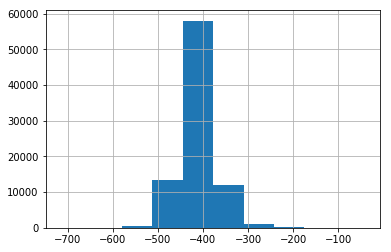

In [8]:
potential.potential_energy.hist()

In [9]:
magnetic.head()

molecule_name  atom_index          XX            YX                 ZX  \
0  dsgdb9nsd_000001           0  195.375000  0.0000000000 -0.000100016593933   
1  dsgdb9nsd_000001           1   31.343750 -1.2314453125  4.054687500000000   
2  dsgdb9nsd_000001           2   31.578125  1.2177734375 -4.148437500000000   
3  dsgdb9nsd_000001           3   31.515625  4.1093750000  1.272460937500000   
4  dsgdb9nsd_000001           4   31.406250 -4.0937500000 -1.179687500000000   

             XY          YY                 ZY                 XZ  \
0  0.0000000000  195.375000  0.000699996948242 -0.000100016593933   
1 -1.2314453125   28.953125 -1.717773437500000  4.054687500000000   
2  1.2177734375   28.906250 -1.603515625000000 -4.148437500000000   
3  4.1093750000   33.906250  1.695312500000000  1.272460937500000   
4 -4.0937500000   34.062500  1.625976562500000 -1.179687500000000   

                  YZ          ZZ  
0  0.000699996948242  195.375000  
1 -1.717773437500000   34.093750  
2 -1.603515625000000   33.906250  
3  1.695312500000000   28.953125  
4  1.625976562500000   28.906250

In [10]:
# train['scalar_coupling_constant'].apply(int).value_counts()

In [11]:
y = train['scalar_coupling_constant']

In [12]:
train = pd.read_csv('train_0.csv', index_col=0)
test = pd.read_csv('test_0.csv', index_col=0)

In [13]:
train_1 = pd.read_csv('train_1.csv', index_col=0)
test_1 = pd.read_csv('test_1.csv', index_col=0)

In [14]:
train = pd.concat([train, train_1], axis=1)
test = pd.concat([test, test_1], axis=1)


In [15]:
train_type = pd.read_csv('input/train.csv.zip', usecols=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])
test_type = pd.read_csv('input/test.csv.zip', usecols=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

train['type'] = train_type.type
test['type'] = test_type.type

train['molecule_name'] = train_type.molecule_name
test['molecule_name'] = test_type.molecule_name


In [16]:
train['atom_index_0'] = train_type.atom_index_0
test['atom_index_0'] = test_type.atom_index_0

train['atom_index_1'] = train_type.atom_index_1
test['atom_index_1'] = test_type.atom_index_1


In [17]:
train = pd.merge(train, scaler, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [18]:
train_babel_feat = pd.read_csv('input/train_ob_charges.csv')
test_babel_feat = pd.read_csv('input/test_ob_charges.csv')


In [19]:
train_babel_feat.shape

(1533537, 15)

In [20]:
train_babel_feat['atom_index_0'] = train_babel_feat.atom_index
train_babel_feat['atom_index_1'] = train_babel_feat.atom_index

test_babel_feat['atom_index_0'] = test_babel_feat.atom_index
test_babel_feat['atom_index_1'] = test_babel_feat.atom_index


In [21]:
bfs =  ['molecule_name', 'atom_index_0'] + ['eem', 'qtpie']

In [22]:
train = train.merge(train_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_0'])

bfs =  ['molecule_name', 'atom_index_1'] + ['eem', 'qtpie']
train = train.merge(train_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_1'])

In [23]:

bfs =  ['molecule_name', 'atom_index_0'] + ['eem', 'qtpie']
test = test.merge(test_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_0'])


In [24]:
bfs =  ['molecule_name', 'atom_index_1'] + ['eem', 'qtpie']
test = test.merge(test_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_1'])

In [25]:
train.head()

atom_index_0  atom_index_1  type  atom_index_x  atom_0      x_0      y_0  \
0             1             0  1JHC             1       0  0.00215 -0.00603   
1             1             2  2JHH             1       0  0.00215 -0.00603   
2             1             3  2JHH             1       0  0.00215 -0.00603   
3             1             4  2JHH             1       0  0.00215 -0.00603   
4             2             0  1JHC             2       0  1.01200  1.46400   

         z_0  EN_x  rad_x  ...  atom_n     molecule_name        fc  \
0  0.0019760   2.2   0.43  ...       4  dsgdb9nsd_000001  83.00000   
1  0.0019760   2.2   0.43  ...       4  dsgdb9nsd_000001 -11.03125   
2  0.0019760   2.2   0.43  ...       4  dsgdb9nsd_000001 -11.03125   
3  0.0019760   2.2   0.43  ...       4  dsgdb9nsd_000001 -11.03125   
4  0.0002766   2.2   0.43  ...       4  dsgdb9nsd_000001  83.00000   

               sd           pso            dso              eem_x  \
0  0.254638671875  1.2587890625  0.27197265625  0.161131359327947   
1  0.353027343750  2.8574218750 -3.43359375000  0.161131359327947   
2  0.353027343750  2.8593750000 -3.43359375000  0.161131359327947   
3  0.353027343750  2.8593750000 -3.43359375000  0.161131359327947   
4  0.254638671875  1.2587890625  0.27197265625  0.161131811379221   

             qtpie_x              eem_y            qtpie_y  
0  0.773439349698371 -0.644530825087479 -3.093806799641671  
1  0.773439349698371  0.161131811379221  0.773442481023162  
2  0.773439349698371  0.161133990721081  0.773463412039650  
3  0.773439349698371  0.161133663659230  0.773461556880489  
4  0.773442481023162 -0.644530825087479 -3.093806799641671  

[5 rows x 124 columns]

In [26]:
train['q_0'] = train['eem_x'] * train['eem_y'] / train['dist'] ** 2
test['q_0'] = test['eem_x'] * test['eem_y'] / test['dist'] ** 2

train['q_1'] = train['qtpie_x'] * train['qtpie_y'] / train['dist'] ** 2
test['q_1'] = test['qtpie_x'] * test['qtpie_y'] / test['dist'] ** 2

In [27]:
scaler.columns

Index(['molecule_name', 'atom_index_0', 'atom_index_1', 'type', 'fc', 'sd',
       'pso', 'dso'],
      dtype='object')

In [28]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

In [29]:
train['dist_0'] = np.linalg.norm(train_p_0 + train_p_1, axis=1)
test['dist_0'] = np.linalg.norm(test_p_0 + test_p_1, axis=1)

train['dist_1'] = np.max(train_p_0 * train_p_1, axis=1)
test['dist_1'] = np.max(test_p_0 * test_p_1, axis=1)

train['dist_2'] = np.min(train_p_0 * train_p_1, axis=1)
test['dist_2'] = np.min(test_p_0 * test_p_1, axis=1)

train['dist_3'] = np.var(train_p_0 * train_p_1, axis=1)
test['dist_3'] = np.var(test_p_0 * test_p_1, axis=1)

In [30]:
train['m_0'] = train.groupby(['molecule_name', 'atom_index_0'])['dist_2'].transform('max')
test['m_0'] = train.groupby(['molecule_name', 'atom_index_0'])['dist_2'].transform('max')

train['d_0'] = np.max(np.abs(train_p_0 - train_p_1), axis=1)
test['d_0'] = np.max(np.abs(test_p_0 - test_p_1), axis=1)


In [31]:
train_2 = pd.read_csv('input/train_2.csv', index_col=0)
test_2 = pd.read_csv('input/test_2.csv', index_col=0)

In [32]:
train_2.head()

id     molecule_name  atom_index_0  atom_index_1  type atom1 atom2  type0  \
0   0  dsgdb9nsd_000001             1             0  1JHC     H     C      0   
1   1  dsgdb9nsd_000001             1             2  2JHH     H     H      1   
2   2  dsgdb9nsd_000001             1             3  2JHH     H     H      1   
3   3  dsgdb9nsd_000001             1             4  2JHH     H     H      1   
4   4  dsgdb9nsd_000001             2             0  1JHC     H     C      0   

   type1  type2  ...  a1_nb_inring8  a1_nb_nb_h  a1_nb_nb_o  a1_nb_nb_c  \
0      0      0  ...              0           0           0           1   
1      0      0  ...              0           4           0           0   
2      0      0  ...              0           4           0           0   
3      0      0  ...              0           4           0           0   
4      0      0  ...              0           0           0           1   

   a1_nb_nb_n  a1_nb_nb_na       x_a1_nb       y_a1_nb       z_a1_nb  \
0           0            0 -0.5238136345  1.4379326443  0.9063972942   
1           0            0 -0.0126981359  1.0858041578  0.0080009958   
2           0            0 -0.0126981359  1.0858041578  0.0080009958   
3           0            0 -0.0126981359  1.0858041578  0.0080009958   
4           0            0 -0.5238136345  1.4379326443  0.9063972942   

   dist_to_type_mean  
0  0.999133993514757  
1  1.004633785679569  
2  1.004649414975929  
3  1.004654592141451  
4  0.999132674975848  

[5 rows x 66 columns]

In [33]:
train_2.drop(labels=['atom_index_0', 'atom_index_1' ,'type' ,'atom1', 'atom2', 'id'], axis=1, inplace=True)
test_2.drop(labels=['atom_index_0', 'atom_index_1' ,'type' ,'atom1', 'atom2', 'id'], axis=1, inplace=True)

In [34]:
train = pd.concat([train, train_2], axis=1)
test = pd.concat([test, test_2], axis=1)


In [35]:
np.unique(train['type'])

array(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'],
      dtype=object)

In [36]:
del train_1, train_2
del test_1, test_2

gc.collect()

98

In [37]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)
#df for evaluate
eval_df = pd.DataFrame({"type": train["type"]})
eval_df["scalar_coupling_constant"] = y

In [38]:
train.head()

atom_index_0  atom_index_1  type  atom_index_x  atom_0      x_0      y_0  \
0             1             0  1JHC             1       0  0.00215 -0.00603   
1             1             2  2JHH             1       0  0.00215 -0.00603   
2             1             3  2JHH             1       0  0.00215 -0.00603   
3             1             4  2JHH             1       0  0.00215 -0.00603   
4             2             0  1JHC             2       0  1.01200  1.46400   

         z_0  EN_x  rad_x  ...  a1_nb_inring8  a1_nb_nb_h  a1_nb_nb_o  \
0  0.0019760   2.2   0.43  ...              0           0           0   
1  0.0019760   2.2   0.43  ...              0           4           0   
2  0.0019760   2.2   0.43  ...              0           4           0   
3  0.0019760   2.2   0.43  ...              0           4           0   
4  0.0002766   2.2   0.43  ...              0           0           0   

   a1_nb_nb_c  a1_nb_nb_n  a1_nb_nb_na       x_a1_nb       y_a1_nb  \
0           1           0            0 -0.5238136345  1.4379326443   
1           0           0            0 -0.0126981359  1.0858041578   
2           0           0            0 -0.0126981359  1.0858041578   
3           0           0            0 -0.0126981359  1.0858041578   
4           1           0            0 -0.5238136345  1.4379326443   

        z_a1_nb  dist_to_type_mean  
0  0.9063972942  0.999133993514757  
1  0.0080009958  1.004633785679569  
2  0.0080009958  1.004649414975929  
3  0.0080009958  1.004654592141451  
4  0.9063972942  0.999132674975848  

[5 rows x 192 columns]

In [39]:
train.shape

(4658147, 192)

In [40]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


In [41]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
n_split = 5
kf = KFold(n_splits=n_split, random_state=666, shuffle=True)
gc.collect()    
for type_ in np.unique(train['type']):

    
    train_ = train[train['type'] == type_].replace([np.inf, -np.inf], np.nan).fillna(-999)
    test_ = test[test['type'] == type_].replace([np.inf, -np.inf], np.nan).fillna(-999)
    
    train_index = train_.index
    test_index = test_.index
    
    y_ = y[train['type'] == type_]
    
    features = [c for c in train_.columns if c not in ['id', 'molecule_name', 'x_0', 'y_0', 'z_0', 'id',
                                                       'x_1', 'y_1', 'z_1', 'atom_index',
                                                       'type', 'scalar_coupling_constant',
                                                       'atom_0', 'atom_1']]

    for i, (train_idx, valid_idx) in enumerate(kf.split(train_)):  
        print(f'Fold {i + 1}')
        x_train = train_[features]
        y_train = y_
       
        clf = ExtraTreesRegressor(n_estimators=2 ** 7, criterion='mae', max_depth=12,
           min_samples_split=2, min_samples_leaf=50, min_weight_fraction_leaf=0.0, 
           max_features=0.95, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
           bootstrap=False, oob_score=False, n_jobs=-1, 
           random_state=666, verbose=0, warm_start=False)
        clf.fit(x_train.iloc[train_idx], y_train.iloc[train_idx])
        
        oof[train_index[valid_idx]] = clf.predict(x_train.iloc[valid_idx])

        predictions[test_index] += clf.predict(test_[features]) / n_split

    
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

Fold 1


KeyboardInterrupt: 

In [ ]:
predictions

In [ ]:
predictions

In [ ]:
test.shape

In [ ]:
sub = pd.read_csv('input/sample_submission.csv.zip')

In [ ]:
sub.head()

In [ ]:
sub.shape

In [ ]:
len(predictions)

In [ ]:
sub['scalar_coupling_constant'] = predictions

sub.to_csv("submission-ET-v0.1.3.csv", index=False)

In [ ]:
sub['scalar_coupling_constant'].hist()

In [ ]:
pd.DataFrame(oof).to_csv('oofs/validation_ET_v0.1.3.csv', index=False)
pd.DataFrame(predictions).to_csv('oofs/test_ET_v0.1.3.csv', index=False)